In [1]:
!pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=42e4f4010bf75aa55ce6fc4222ae9335072c445ad1f8abb029a37ef163f2a69d
  Stored in directory: /root/.cache/pip/wheels/fa/f7/53/a55a8a56668a6fe0199e0e02b6e0ae3007ec35cdf6e4c25df7
Successfully built factor_analyzer


In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from factor_analyzer import FactorAnalyzer
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

warnings.filterwarnings('ignore')

In [23]:
data = pd.read_excel('/content/drive/MyDrive/유비온/팀프로젝트1/Data/ts_rtn_2015_2020.xlsx', dtype = {'주식코드':str})

In [24]:
data.head()

,회사명,주식코드,연도,총자본증가율(IFRS),유형자산증가율(IFRS),투자부동산증가율(IFRS),비유동자산증가율(IFRS),유동자산증가율(IFRS),재고자산증가율(IFRS),자기자본증가율(IFRS),...,운전자본회전률(IFRS),1회전기간(IFRS),총자본투자효율(IFRS),설비투자효율(IFRS),기계투자효율(IFRS),부가가치율(IFRS),노동소득분배율(IFRS),자본분배율(IFRS),이윤분배율(IFRS),수익률
0,(주)경방,000050,2015,-1.22,-4.16,-1.29,-1.31,0.11,8.61,3.10,...,1.51,0.02,8.57,41.80,379.17,35.08,19.66,80.34,20.01,-0.335878
1,(주)경방,000050,2016,-1.79,-3.70,-1.30,-1.64,-3.85,-10.48,2.75,...,0.00,0.02,8.89,44.22,502.67,35.04,19.01,80.99,28.16,-0.155172
2,(주)경방,000050,2017,-3.07,-7.75,-1.26,-2.50,-11.26,-33.22,3.00,...,0.52,0.02,9.12,47.66,647.91,37.96,18.25,81.75,23.48,0.013605
3,(주)경방,000050,2018,2.29,-6.58,-1.13,0.96,23.35,58.28,2.56,...,0.60,0.02,7.22,41.34,1552.83,31.75,19.89,80.11,32.96,-0.248322
4,(주)경방,000050,2019,5.68,-69.74,5.71,-5.79,153.86,-60.76,1.58,...,0.23,0.02,6.22,134.74,18933.42,31.82,15.85,84.15,27.55,-0.107143


In [25]:
y = data.iloc[:, -1]
x_data = data.iloc[:, 3:-1]

In [26]:
# 2. 상관 행렬 계산
# abs()를 사용하여 상관 계수의 절댓값을 취합니다.
corr_matrix = x_data.corr().abs()

print("--- 상관 행렬 (절댓값) ---")
print(corr_matrix)
print("-" * 50)

# 3. 중복된 쌍을 제외하고 대각선을 제외한 값들만 추출
# 상관 행렬은 대칭적이므로, 중복된 쌍(예: (A,B)와 (B,A))을 피하고
# 자기 자신과의 상관관계(대각선 값, 항상 1)도 제외합니다.
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 4. 극도로 높은 상관관계를 가진 변수 쌍 찾기
# 임계값(threshold) 설정: 0.95, 0.99 등 매우 높은 값을 사용합니다.
# 1에 가까울수록 선형 종속성이 강합니다.
threshold = 0.9
highly_correlated_pairs = upper_tri.stack()
highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs >= threshold]

print(f"--- 상관 계수 절댓값 {threshold} 이상인 변수 쌍 ---")
if not highly_correlated_pairs.empty:
    print(highly_correlated_pairs.sort_values(ascending=False))
    print("\n이 변수 쌍 중 하나를 제거해야 할 가능성이 높습니다.")

    # 제거할 변수 목록 (예시 로직: 각 쌍에서 두 번째 변수를 제거)
    # 실제로는 도메인 지식을 바탕으로 어떤 변수를 제거할지 결정하는 것이 좋습니다.
    # (예: 정보량이 더 적거나, 이론적으로 덜 중요한 변수)
    cols_to_drop = []
    for (col1, col2), corr_val in highly_correlated_pairs.items():
        if col2 not in cols_to_drop: # 이미 제거 목록에 없는 경우만 추가
            cols_to_drop.append(col2) # 일단 두 번째 변수를 제거 후보로 추가

    # 중복 제거 (필요하다면)
    cols_to_drop = list(set(cols_to_drop))

    if cols_to_drop:
        print(f"\n제거할 변수 후보: {cols_to_drop}")
        x_data_cleaned = x_data.drop(columns=cols_to_drop)
        print("\n--- 상관관계 높은 변수 제거 후 x_data의 shape ---")
        print(x_data_cleaned.shape)
        print(f"남은 컬럼: {x_data_cleaned.columns.tolist()}")
    else:
        x_data_cleaned = x_data.copy() # 제거할 컬럼이 없으면 원본 유지
        print("제거할 변수 후보가 없습니다.")

else:
    print("설정한 임계값 이상의 극도로 높은 상관관계를 가진 변수 쌍이 없습니다.")
    x_data_cleaned = x_data.copy() # 제거할 컬럼이 없으면 원본 유지


--- 상관 행렬 (절댓값) ---
                총자본증가율(IFRS)  유형자산증가율(IFRS)  투자부동산증가율(IFRS)  비유동자산증가율(IFRS)  \
총자본증가율(IFRS)        1.000000       0.020970        0.020738        0.818722   
유형자산증가율(IFRS)       0.020970       1.000000        0.001441        0.002619   
투자부동산증가율(IFRS)      0.020738       0.001441        1.000000        0.032545   
비유동자산증가율(IFRS)      0.818722       0.002619        0.032545        1.000000   
유동자산증가율(IFRS)       0.227773       0.064774        0.000487        0.010089   
...                      ...            ...             ...             ...   
기계투자효율(IFRS)        0.003579       0.002564        0.002166        0.150394   
부가가치율(IFRS)         0.171749       0.004093        0.007346        0.234212   
노동소득분배율(IFRS)       0.035067       0.003618        0.003847        0.019912   
자본분배율(IFRS)         0.039907       0.003285        0.004283        0.024834   
이윤분배율(IFRS)         0.080937       0.002134        0.000630        0.059723   

                유동자산증가율(IFRS)  

In [27]:
# 상관관계가 0.3보다 낮은 값들만 구성된 컬럼은 제거
corr = x_data_cleaned.corr()

In [28]:
# 각 컬럼별로, 자기 자신을 제외한 나머지 컬럼들과의 상관계수 절대값이 모두 0.3 미만인지 확인
cols_to_drop = []
for col in corr.columns:
    # 자기 자신 제외 (상관계수 1)
    other_corrs = corr[col].drop(col)
    if all(other_corrs.abs() < 0.5):
        cols_to_drop.append(col)

In [29]:
# 해당 컬럼 삭제
filtered_data = x_data_cleaned.drop(columns=cols_to_drop)

In [30]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(filtered_data)

df_scaled = pd.DataFrame(data_scaled, columns=filtered_data.columns, index=filtered_data.index)

kmo_all, kmo_per_variable = calculate_kmo(df_scaled)

print(kmo_all)
print(kmo_per_variable)

[0.54486559 0.60839519 0.54936141 0.40641975 0.73828697 0.47206996
 0.6614922  0.40981617 0.54354162 0.63694345 0.58892476 0.50378466
 0.6534228  0.67633673 0.78898787 0.78843715 0.79754157 0.4042066
 0.84053024 0.37974559 0.77750507 0.64104637 0.82813534 0.61739128
 0.79657817 0.7251245  0.7731903  0.83702348 0.79364391 0.67846177
 0.56295486 0.61312283 0.74380599 0.72585942 0.86916049 0.68410845
 0.59918302 0.64921044 0.47485342 0.63342116 0.77809284 0.48106778
 0.73929349 0.8283456  0.7273776  0.73702838 0.648021   0.87080886
 0.62000205 0.58417847 0.6690523  0.69781943 0.81524229 0.70438692
 0.78830902 0.64624727 0.84718506 0.63178503 0.72986726 0.61561764
 0.43060967]
0.6566731843661273


In [31]:
# Bartlett 구형성 검정
chi_square_value, p_value = calculate_bartlett_sphericity(df_scaled)
print("--- Bartlett 구형성 검정 결과 ---")
print(f"카이제곱 통계량: {chi_square_value:.4f}")
print(f"P-value: {p_value:.4f}")
print("-" * 50)

--- Bartlett 구형성 검정 결과 ---
카이제곱 통계량: 103864.5757
P-value: 0.0000
--------------------------------------------------


In [32]:
def parallel_analysis_scree_plot(data, n_iter=100, random_state=None):
    """
    평행 분석과 스크리 도표를 결합한 시각화 함수
    """
    # 데이터 표준화
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # 실제 데이터 요인 분석
    fa = FactorAnalyzer(rotation='varimax', use_smc=True, method = 'principal')
    fa.fit(data_scaled)
    real_eigenvalues, _ = fa.get_eigenvalues()

    # 무작위 데이터 생성 및 분석
    n_samples, n_features = data.shape
    random_eigenvalues = np.zeros((n_iter, n_features))

    np.random.seed(random_state)
    for i in range(n_iter):
        random_data = np.random.normal(size=(n_samples, n_features))
        fa.fit(random_data)
        rand_eig, _ = fa.get_eigenvalues()
        random_eigenvalues[i] = rand_eig

    # 평균 및 95th 백분위수 계산
    mean_random_eigen = np.mean(random_eigenvalues, axis=0)
    percentile_95 = np.percentile(random_eigenvalues, 95, axis=0)

    # 시각화 설정
    plt.figure(figsize=(10, 6))
    components = range(1, n_features+1)

    # 실제 데이터 스크리 플롯
    plt.plot(components, real_eigenvalues, 'bo-',
             linewidth=2, label='Actual Data')

    # 무작위 데이터 평균/95th
    plt.plot(components, mean_random_eigen, 'r--',
             linewidth=2, label='Random Mean')
    plt.plot(components, percentile_95, 'g-.',
             linewidth=2, label='95th Percentile')

    # 카이저 기준선
    plt.axhline(y=1, color='k', linestyle='--', label='Kaiser Criterion')

    # 교차점 강조
    optimal_factors = np.where(real_eigenvalues > percentile_95)[0]
    if len(optimal_factors) > 0:
        plt.scatter(optimal_factors+1, real_eigenvalues[optimal_factors],
                    s=200, facecolors='none', edgecolors='m',
                    label='Optimal Factors')

    plt.title('Parallel Analysis Scree Plot')
    plt.xlabel('Factor Number')
    plt.ylabel('Eigenvalue')
    plt.xticks(components)
    plt.legend()
    plt.grid(True)
    plt.show()

    # 최적 요인 수 제안
    suggested_factors = len(optimal_factors)
    print(f'Suggested number of factors: {suggested_factors}')
    return suggested_factors

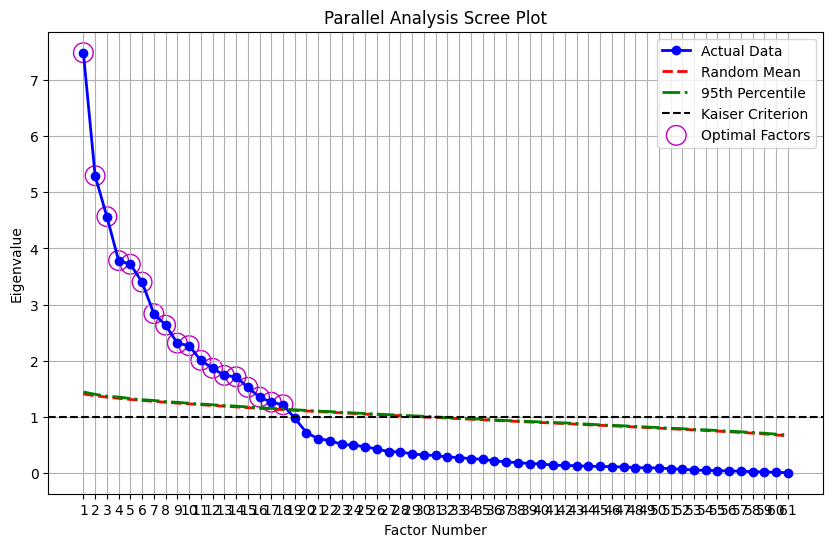

Suggested number of factors: 18


In [33]:
# 최적의 요인 개수 찾기
optim = parallel_analysis_scree_plot(filtered_data, n_iter=100, random_state=42)

In [34]:
# FactorAnalyzer 초기화 및 fit
fa = FactorAnalyzer(n_factors=optim, method='principal', rotation='varimax')
fa.fit(data_scaled)

FactorAnalyzer(method='principal', n_factors=18, rotation='varimax',
               rotation_kwargs={})

In [35]:
# 1. 요인 점수 (Factor Scores)
factor_scores = fa.transform(data_scaled)
factor_scores_df = pd.DataFrame(factor_scores, columns=[f"factor_{i+1}" for i in range(optim)], index=data.index)

In [36]:
# 2. 요인 부하량 (Factor Loadings)
factor_loadings = pd.DataFrame(fa.loadings_, index=filtered_data.columns, columns=[f"factor_{i+1}" for i in range(optim)])

In [37]:
factor_loadings

,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,factor_11,factor_12,factor_13,factor_14,factor_15,factor_16,factor_17,factor_18
총자본증가율(IFRS),0.011431,0.018949,0.007070,-0.066319,0.074974,-0.006879,-0.000093,0.075981,-0.013712,0.076522,0.036706,0.002183,0.920512,0.080127,-0.043787,-0.019309,0.136696,0.003167
유형자산증가율(IFRS),0.005162,-0.031528,0.012885,0.020052,-0.001513,0.014658,-0.021513,0.954521,0.000319,-0.009180,-0.005554,-0.000495,-0.035718,-0.019521,0.004986,-0.001089,-0.031992,-0.007061
비유동자산증가율(IFRS),0.009823,0.004359,-0.017374,-0.049238,0.054525,0.035908,0.014818,0.042867,0.026231,0.116067,-0.034265,0.005632,0.919044,0.044961,-0.002300,-0.033790,-0.020886,-0.014575
유동자산증가율(IFRS),0.019220,-0.080296,0.057571,-0.023068,0.000807,-0.012435,-0.009070,0.092440,-0.011641,0.009033,0.033954,-0.003788,0.073760,0.004596,-0.039513,0.032463,0.859321,0.036988
매출액증가율(IFRS),0.004232,0.004248,-0.000323,-0.028992,-0.000012,-0.038871,0.030517,0.878073,-0.000723,0.006989,-0.037378,0.000765,0.090916,0.039702,0.004468,-0.001060,0.208300,0.012289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
유형자산회전율(IFRS),0.006492,-0.057879,0.698146,-0.017008,0.004677,0.011818,-0.048330,0.006356,0.002337,-0.043483,0.035121,-0.004336,-0.005150,-0.019426,0.023085,-0.024278,0.020601,0.016525
순운전자본회전률(IFRS),-0.005605,0.912697,-0.090718,-0.045274,0.071439,-0.050216,0.085541,0.007140,-0.024102,-0.038336,-0.014144,0.041057,0.013524,0.192842,-0.023562,-0.020455,-0.035855,-0.086697
운전자본회전률(IFRS),0.017202,-0.045012,-0.003981,0.015391,-0.011362,0.038837,-0.063556,-0.027456,-0.004776,0.084384,-0.009277,-0.000994,-0.043347,-0.015180,0.889603,-0.000551,-0.005998,-0.005527
총자본투자효율(IFRS),0.011174,0.327210,-0.083902,0.003017,0.053353,-0.026349,0.115825,-0.011670,0.058974,0.295394,0.208429,-0.010434,0.114271,0.634837,-0.047762,0.000446,-0.007430,-0.119386


In [38]:
# def make_factor_analysis_results(n_factors, data):


#     # FactorAnalyzer 초기화 및 fit
#     fa = FactorAnalyzer(n_factors=n_factors, method='principal', rotation='varimax')
#     fa.fit(data_scaled)

#     # 1. 요인 점수 (Factor Scores)
#     factor_scores = fa.transform(data_scaled)
#     factor_scores_df = pd.DataFrame(factor_scores, columns=[f"factor_{i+1}" for i in range(n_factors)], index=data.index)

#     # 2. 요인 부하량 (Factor Loadings)
#     factor_loadings = pd.DataFrame(fa.loadings_, index=data.columns, columns=[f"factor_{i+1}" for i in range(n_factors)])

#     # 3. 각 요인의 설명 분산 (Variance) 및 누적 설명 분산 (Cumulative Variance)
#     # get_factor_variance()는 세 가지 배열을 반환합니다:
#     # (고유값, 요인 분산, 누적 요인 분산)
#     eigen_values, factor_variance, cumulative_variance = fa.get_factor_variance()

#     # 결과를 DataFrame으로 보기 좋게 정리
#     variance_df = pd.DataFrame({
#         '고유값 (Eigenvalue)': eigen_values[:n_factors], # 추출된 요인 수만큼만
#         '설명 분산 (Proportion of Variance)': factor_variance[:n_factors],
#         '누적 설명 분산 (Cumulative Variance)': cumulative_variance[:n_factors]
#     }, index=[f'Factor {i+1}' for i in range(n_factors)])

#     print("\n--- 각 요인의 설명 분산 및 누적 설명 분산 ---")
#     print(variance_df)
#     print("-" * 50)

#     return factor_scores_df, factor_loadings, variance_df # variance_df도 함께 반환

In [39]:
filtered_data.columns

Index(['총자본증가율(IFRS)', '유형자산증가율(IFRS)', '비유동자산증가율(IFRS)', '유동자산증가율(IFRS)',
       '매출액증가율(IFRS)', '종업원1인당 부가가치증가율(IFRS)', '종업원수증가율(IFRS)',
       '매출액정상영업이익률(IFRS)', '매출액순이익률(IFRS)', '총자본사업이익률(IFRS)', '총자본순이익률(IFRS)',
       '자기자본정상영업이익률(IFRS)', '자기자본순이익률(IFRS)', '경영자본정상영업이익률(IFRS)',
       '경영자본순이익률(IFRS)', '자본금정상영업이익률(IFRS)', '자본금순이익률(IFRS)', '기타손익비률(IFRS)',
       '금융손익비율(IFRS)', '금융비용부담률(IFRS)', '수지비율(관계기업투자손익 제외)(IFRS)',
       '금융비용 대 총비용비율(IFRS)', '감가상각비 대 총비용비율(IFRS)', '지급이자율(IFRS)',
       '차입금평균이자율(IFRS)', '유보율(IFRS)', '사내유보 대 자기자본비율(IFRS)',
       '적립금비율(재정비율)(IFRS)', '평균배당률(IFRS)', '자기자본배당률(IFRS)', '유동자산구성비율(IFRS)',
       '유동자산 대 비유동자산비율(IFRS)', '자기자본구성비율(IFRS)', '비유동비율(IFRS)',
       '비유동장기적합률(IFRS)', '유동비율(IFRS)', '현금비율(IFRS)', '매출채권비율(IFRS)',
       '재고자산 대 순운전자본비율(IFRS)', '매입채무 대 재고자산비율(IFRS)', '유동부채비율(IFRS)',
       '비유동부채 대 순운전자본비율(IFRS)', '순운전자본비율(IFRS)', '차입금의존도(IFRS)', '투자집중도(IFRS)',
       'CASH FLOW 대 부채비율(IFRS)', 'CASH FLOW 대 차입금비율(IFRS)',
       'CASH FLOW 대 총

In [40]:
X = factor_scores_df

In [41]:
X_with_const = sm.add_constant(X)

In [42]:
model_rlm = sm.RLM(y, X_with_const, M=sm.robust.norms.HuberT())
results_rlm = model_rlm.fit()
results_rlm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                    수익률   No. Observations:                 1544
Model:                            RLM   Df Residuals:                     1525
Method:                          IRLS   Df Model:                           18
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 28 May 2025                                         
Time:                        04:45:55                                         
No. Iterations:                    24                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.009      0.243      0.808      -0.015       0.019
factor_1       0.0181      0.009      2.069      0.039       0.001       0.035
factor_2      -0.0172      0.009     -1.969      0.049      -0.034   -8.22e-05
factor_3       0.0063      0.009      0.718      0.473      -0.011       0.023
factor_4      -0.0199      0.009     -2.277      0.023      -0.037      -0.003
factor_5       0.0028      0.009      0.323      0.747      -0.014       0.020
factor_6       0.0069      0.009      0.785      0.432      -0.010       0.024
factor_7       0.0086      0.009      0.982      0.326      -0.009       0.026
factor_8      -0.0057      0.009     -0.657      0.511      -0.023       0.011
factor_9      -0.0007      0.009     -0.079      0.937      -0.018       0.016
factor_10      0.0235      0.009      2.688      0.007       0.006       0.041
factor_11      0.0026      0.009      0.299      0.765      -0.015       0.020
factor_12     -0.0002      0.009     -0.025      0.980      -0.017       0.017
factor_13      0.0040      0.009      0.462      0.644      -0.013       0.021
factor_14      0.0332      0.009      3.804      0.000       0.016       0.050
factor_15     -0.0086      0.009     -0.982      0.326      -0.026       0.009
factor_16      0.0040      0.009      0.460      0.646      -0.013       0.021
factor_17      0.0015      0.009      0.175      0.861      -0.016       0.019
factor_18     -0.0069      0.009     -0.794      0.427      -0.024       0.010
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [43]:
factor_list = ['factor_1', 'factor_2', 'factor_4', 'factor_10', 'factor_14']

In [44]:
factor_coefficients_for_backtest = results_rlm.params[factor_list]

In [45]:
test_start_year = 2021
test_end_year = 2024 # 테스트 기간 끝 연도 (학습된 모델을 이 기간에 적용)

num_top_firms = 10 # 매년 매수할 상위 기업 수

portfolio_returns_annual = [] # 각 연도별 포트폴리오 수익률 저장
portfolio_years = [] # 수익률이 계산된 연도 저장

In [46]:
df_original = pd.read_excel('/content/drive/MyDrive/유비온/팀프로젝트1/Data/ts_rtn_2021_2024.xlsx', dtype = {'주식코드':str})

In [47]:
df = df_original[filtered_data.columns]

In [48]:
df_original.iloc[:, -1:]

,수익률
0,0.209125
1,-0.335849
2,-0.277462
3,-0.081258
4,-0.379286
...,...
1130,0.162092
1131,-0.527257
1132,-0.300000
1133,-0.415695


In [49]:
df1 = pd.merge(df_original.iloc[:, :3], df, left_index=True, right_index=True, how = 'outer')

In [50]:
last_df = pd.merge(df1, df_original.iloc[:, -1:], left_index=True, right_index=True, how = 'outer')

In [51]:
return_col_name = '수익률'

In [52]:
test_start_year

2021

In [53]:
test_end_year

2024

In [54]:
for current_year in range(test_start_year, test_end_year + 1):
    print(f"\n--- 백테스팅 연도: {current_year} ---")

    # 현재 연도(테스트 기간)의 원본 재무 변수 데이터 추출
    current_year_data_raw = last_df[last_df['연도'] == current_year].copy()

    # 재무 변수와 수익률 분리
    x_current_year_raw = current_year_data_raw.iloc[:, 3:-1]
    y_current_year = current_year_data_raw.iloc[:, -1:]

    # 2-1. 재무 변수 전처리 (표준화)
    # 학습 기간에 fit 된 `scaler_financial` 객체를 사용하여 현재 연도 데이터를 `transform`만 합니다.
    # 이는 학습 기간과 동일한 기준으로 데이터를 표준화하기 위함입니다.

    # 학습된 변수 필터링 목록 (x_train_filtered_final의 컬럼들)과 현재 데이터의 공통 컬럼만 선택
    # Factor 모델은 학습된 컬럼 순서와 개수를 기대하므로 맞춰줍니다.
    common_cols_for_factor = list(set(filtered_data.columns) & set(x_current_year_raw.columns))

    if not common_cols_for_factor:
        print(f"  {current_year}년도 데이터에 학습 기간에서 사용된 재무 변수가 없습니다. 다음 연도로 이동.")
        portfolio_returns_annual.append(0)
        portfolio_years.append(current_year)
        continue

    # 학습된 필터링된 컬럼의 순서에 맞춰 현재 데이터를 재정렬
    x_current_year_aligned = x_current_year_raw[filtered_data.columns].copy()
    x_current_year_scaled = pd.DataFrame(scaler.transform(x_current_year_raw),
                                         columns=x_current_year_raw.columns,
                                         index=x_current_year_raw.index)


    # 2-2. 고정된 Factor 모델 (fa_fixed_model)을 사용하여 Factor Score 계산
    # 학습 기간에서 fit된 FactorAnalyzer 객체를 사용하여 현재 연도 데이터를 transform 합니다.
    # 이렇게 하면 현재 연도의 재무 변수들이 학습 기간에 정의된 Factor 구조에 따라 Factor Score로 변환됩니다.
    current_year_factor_scores = pd.DataFrame(fa.transform(x_current_year_scaled),
                                              columns=[f"factor_{i+1}" for i in range(optim)],
                                              index=x_current_year_scaled.index)

    # 2-3. Z-score 계산 (현재 연도 Factor Score 바탕)
    # Factor Score 자체의 Z-score는 매년 해당 연도의 기업들 사이에서의 상대적 순위를 반영해야 하므로, 매년 새로 계산합니다.
    # 고정된 유의한 Factor들만 선택합니다.
    factors_for_zscore_names = [f for f in factor_list if f in current_year_factor_scores.columns]

    if not factors_for_zscore_names:
        print(f"  {current_year}년도 데이터에 백테스팅에 사용할 유의한 Factor 컬럼이 없습니다. 다음 연도로 이동.")
        portfolio_returns_annual.append(0)
        portfolio_years.append(current_year)
        continue

    factor_scores_for_zscore = current_year_factor_scores[factors_for_zscore_names]

    scaler_z_period = StandardScaler()
    z_scores_period = scaler_z_period.fit_transform(factor_scores_for_zscore)
    z_scores_df_period = pd.DataFrame(z_scores_period,
                                       columns=[f"{col}_zscore" for col in factors_for_zscore_names],
                                       index=factor_scores_for_zscore.index)

    # 2-4. Z-score 조정 (고정된 회귀 계수 부호에 따라)
    # 학습 기간에 고정된 RLM 회귀 계수의 부호를 사용하여 Z-score의 방향성을 조정합니다.
    adjusted_z_scores_period = z_scores_df_period.copy()
    for factor in factors_for_zscore_names:
        # 고정된 RLM 계수가 음수이면 Z-score 순위를 반전 (높은 Z-score가 좋은 기업이 되도록)
        if factor_coefficients_for_backtest[factor] < 0:
            adjusted_z_scores_period[f"{factor}_zscore"] *= -1

    # 2-5. 기업별 최종 랭크 점수 계산 (조정된 Z-score 합산)
    # 조정된 Z-score들을 합산하여 각 기업의 최종 랭크 점수를 계산합니다.
    firm_rank_score_period = adjusted_z_scores_period.sum(axis=1)
    firm_rank_score_period = firm_rank_score_period.sort_values(ascending=False)

    # 2-6. 포트폴리오 구성: 상위 N개 기업 선정
    # 랭크 점수가 가장 높은 상위 'num_top_firms' 개 기업을 선정합니다.
    top_firms_indices = firm_rank_score_period.head(num_top_firms).index

    # 선정된 기업들의 '주식코드'와 '수익률'을 가져옵니다.
    portfolio_firms_info = current_year_data_raw.loc[top_firms_indices]
    top_firms_codes = portfolio_firms_info['주식코드'].tolist()

    if not top_firms_codes:
        print(f"  {current_year}년도에 포트폴리오에 편입할 기업이 없습니다. 다음 연도로 이동.")
        portfolio_returns_annual.append(0)
        portfolio_years.append(current_year)
        continue

    # 2-7. 포트폴리오 수익률 계산 (선정된 기업들의 현재 연도 '수익률' 평균)
    # 선정된 기업들의 해당 연도 수익률을 평균하여 포트폴리오의 연간 수익률로 간주합니다 (동일 가중 포트폴리오).
    portfolio_avg_return = portfolio_firms_info[return_col_name].mean()
    portfolio_returns_annual.append(portfolio_avg_return)
    portfolio_years.append(current_year)
    print(f"  {current_year}년도 포트폴리오 평균 수익률: {portfolio_avg_return:.2%}")


--- 백테스팅 연도: 2021 ---
  2021년도 포트폴리오 평균 수익률: -13.56%

--- 백테스팅 연도: 2022 ---
  2022년도 포트폴리오 평균 수익률: -14.52%

--- 백테스팅 연도: 2023 ---
  2023년도 포트폴리오 평균 수익률: 69.65%

--- 백테스팅 연도: 2024 ---
  2024년도 포트폴리오 평균 수익률: -5.61%



--- 최종 백테스팅 연간 수익률 ---
2021   -0.135608
2022   -0.145217
2023    0.696487
2024   -0.056149
dtype: float64

--- 누적 수익률 ---
2021    0.864392
2022    0.738867
2023    1.253479
2024    1.183097
dtype: float64


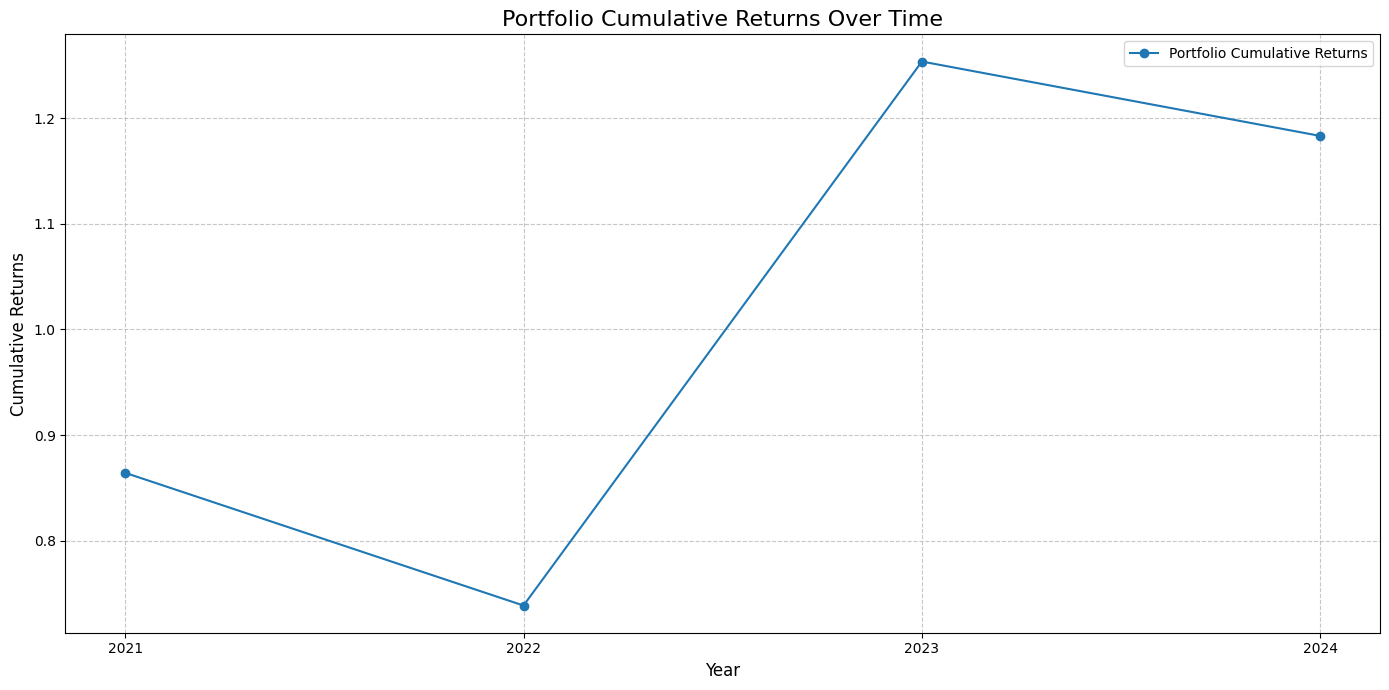


--- 백테스팅 성과 요약 ---
총 백테스팅 기간: 2021년 - 2024년 (4년)
연평균 수익률 (CAGR): 4.29%
연간 변동성 (Standard Deviation): 40.64%
샤프 비율 (무위험 이자율 2.00%): 0.06


In [55]:
if not portfolio_returns_annual:
    print("\n백테스팅을 수행할 충분한 데이터가 없거나 모든 연도에서 포트폴리오 구성에 실패했습니다.")
else:
    portfolio_returns_series = pd.Series(portfolio_returns_annual, index=portfolio_years)

    print("\n--- 최종 백테스팅 연간 수익률 ---")
    print(portfolio_returns_series)

    # 누적 수익률 계산
    cumulative_returns = (1 + portfolio_returns_series).cumprod()
    print("\n--- 누적 수익률 ---")
    print(cumulative_returns)

    # 시각화: 포트폴리오 누적 수익률 그래프
    plt.figure(figsize=(14, 7))
    plt.plot(cumulative_returns.index, cumulative_returns.values, marker='o', linestyle='-', label='Portfolio Cumulative Returns')
    plt.title('Portfolio Cumulative Returns Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Cumulative Returns', fontsize=12)
    plt.xticks(cumulative_returns.index)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    # 추가적인 성과 지표 계산
    total_years = len(portfolio_returns_series)
    if total_years > 0:
        # 연평균 수익률 (CAGR: Compound Annual Growth Rate)
        annualized_return = (cumulative_returns.iloc[-1])**(1/total_years) - 1
        # 연간 변동성 (표준편차)
        annualized_volatility = portfolio_returns_series.std()

        # 무위험 이자율 가정 (예: 2%) - 실제 분석에서는 시장 상황에 맞는 무위험 이자율을 사용해야 합니다.
        risk_free_rate = 0.02
        sharpe_ratio = np.nan
        if annualized_volatility > 0:
            sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

        print(f"\n--- 백테스팅 성과 요약 ---")
        print(f"총 백테스팅 기간: {portfolio_returns_series.index.min()}년 - {portfolio_returns_series.index.max()}년 ({total_years}년)")
        print(f"연평균 수익률 (CAGR): {annualized_return:.2%}")
        print(f"연간 변동성 (Standard Deviation): {annualized_volatility:.2%}")
        print(f"샤프 비율 (무위험 이자율 {risk_free_rate:.2%}): {sharpe_ratio:.2f}")
    else:
        print("\n백테스팅 결과가 없어 성과 지표를 계산할 수 없습니다.")